📓 Notebook 5 — Feature Engineering for Enhanced Models
Context

This notebook continues the investor risk profiling project by advancing from baseline → tuned models (Notebook 4) into new feature engineering and deployment preparation.
Focus: create richer behavioral and portfolio-derived features, test their effect on predictive performance, and prepare for deployment with explainability.

In [1]:
# Cell 1 — Setup & Imports

from google.colab import drive
drive.mount('/content/drive')

import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Paths
BASE_DIR = "/content/drive/MyDrive/portfoliai"
PROC_DIR = f"{BASE_DIR}/data/processed"
MODEL_DIR = f"{BASE_DIR}/models"

print("✅ Directories ready.")


Mounted at /content/drive
✅ Directories ready.


In [2]:
# Cell 2 — Load Enriched Dataset + Tuned Model
import joblib

# Load enriched FAR dataset (from Notebook 3)
far = pd.read_csv(f"{PROC_DIR}/far_customers_features.csv")
print("✅ Enriched dataset loaded. Shape:", far.shape)

# Load tuned Random Forest model (from Notebook 4)
rf_model_path = f"{MODEL_DIR}/tuned_random_forest.pkl"
best_rf = joblib.load(rf_model_path)
print("✅ Tuned Random Forest model loaded.")


✅ Enriched dataset loaded. Shape: (32124, 11)
✅ Tuned Random Forest model loaded.


Cell 3 — New Feature Engineering Setup

So far, our features have focused on simple behavioral metrics (e.g., average/max trade size, number of trades, portfolio shares). These were effective, but as we saw in Notebook 4, predictive power is still limited (~0.49 balanced accuracy).

To improve, we’ll engineer second-order behavioral features that capture more subtle investor patterns:

Volatility Features

Trade Value Volatility: standard deviation of trade sizes.

Relative Trade Volatility: volatility divided by mean trade size.

Portfolio Consistency Features

Allocation Volatility: std. deviation of stock/bond/fund shares across periods (if historical data exists).

Diversification Consistency: variation in number of assets held over time.

Ratio & Normalization Features

Max/Avg Trade Ratio: detects whether large trades are “outliers” relative to normal behavior.

Turnover Proxy: ratio of total traded value to average portfolio value.

Log-Transformed Features

Helps normalize skewed distributions (e.g., log(max_trade_value) and log(avg_trade_value)).

These features aim to better capture risk-taking patterns, stability vs. opportunism, and scaling behavior — elements strongly linked to risk profiles.

In [3]:
# Cell 3 — Feature Engineering Functions

def engineer_new_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    Create new behavioral and portfolio-derived features
    to extend beyond the baseline feature set.
    """
    df = df.copy()

    # --- Volatility Features ---
    if "trade_values" in df.columns:  # assuming transaction-level aggregates available
        df["trade_value_volatility"] = df["trade_values"].apply(np.std)
        df["trade_value_rel_volatility"] = (
            df["trade_value_volatility"] / df["avg_trade_value"].replace(0, np.nan)
        )

    # --- Ratio Features ---
    if "max_trade_value" in df.columns and "avg_trade_value" in df.columns:
        df["max_avg_trade_ratio"] = (
            df["max_trade_value"] / df["avg_trade_value"].replace(0, np.nan)
        )

    # --- Log-Transformed Features ---
    for col in ["avg_trade_value", "max_trade_value", "n_trades"]:
        if col in df.columns:
            df[f"log_{col}"] = np.log1p(df[col])  # log(1+x) to handle zeros safely

    # --- Placeholder for portfolio consistency (future extension) ---
    # If we had time-series allocation data:
    # df["allocation_volatility"] = df.groupby("customer_id")["stock_share"].transform("std")

    return df


# Apply to FAR dataset
far_enhanced = engineer_new_features(far)
print("✅ New features engineered. Shape:", far_enhanced.shape)

# Quick peek
far_enhanced.head()


✅ New features engineered. Shape: (32124, 15)


,customerID,n_trades,avg_trade_value,max_trade_value,trade_freq,n_assets,n_markets,stock_share,bond_share,fund_share,riskLevel_clean,max_avg_trade_ratio,log_avg_trade_value,log_max_trade_value,log_n_trades
0,00017496858921195E5A,496,5874.604944,34880.000000,103,13,2,1.0,0.0,0.0,Aggressive,5.937421,8.678564,10.459698,6.208590
1,00017496858921195E5A,496,5874.604944,34880.000000,103,13,2,1.0,0.0,0.0,Aggressive,5.937421,8.678564,10.459698,6.208590
2,00017496858921195E5A,496,5874.604944,34880.000000,103,13,2,1.0,0.0,0.0,Aggressive,5.937421,8.678564,10.459698,6.208590
3,00017496858921195E5A,496,5874.604944,34880.000000,103,13,2,1.0,0.0,0.0,Aggressive,5.937421,8.678564,10.459698,6.208590
4,00024864C985E72167A0,1,4999.993985,4999.993985,1,1,1,0.0,0.0,1.0,Conservative,1.000000,8.517392,8.517392,0.693147


Cell 4 — Exploratory Analysis of New Features

To validate whether our new engineered features add value, we’ll:

Inspect distributions of the new features (e.g., log-transformed values, ratios, volatility).

Check whether they reduce skewness compared to raw features.

Detect extreme outliers or clustering.

Check correlations with the target (riskLevel_clean).

Do the new features separate Aggressive vs. Conservative investors better than the old ones?

Compare feature relationships visually using boxplots/violin plots.

Example: Do Aggressive investors have higher max_avg_trade_ratio?

Does volatility differ significantly across risk profiles?

This step helps confirm whether the new engineered features truly capture behavioral signals relevant to risk profiling — before we include them in new models.

✅ Available new features: ['max_avg_trade_ratio', 'log_avg_trade_value', 'log_max_trade_value', 'log_n_trades']
=== Summary Statistics of New Features ===


,count,mean,std,min,25%,50%,75%,max
max_avg_trade_ratio,32124.0,3.111541,9.927298,1.000000,1.066667,1.516944,2.641471,455.220036
log_avg_trade_value,32124.0,7.203303,1.986003,0.071017,6.266932,7.314935,8.410125,16.833933
log_max_trade_value,32124.0,7.830016,2.209597,0.071017,6.688355,7.931927,9.210440,17.117223
log_n_trades,32124.0,2.103787,1.384869,0.693147,1.098612,1.609438,2.564949,8.999743


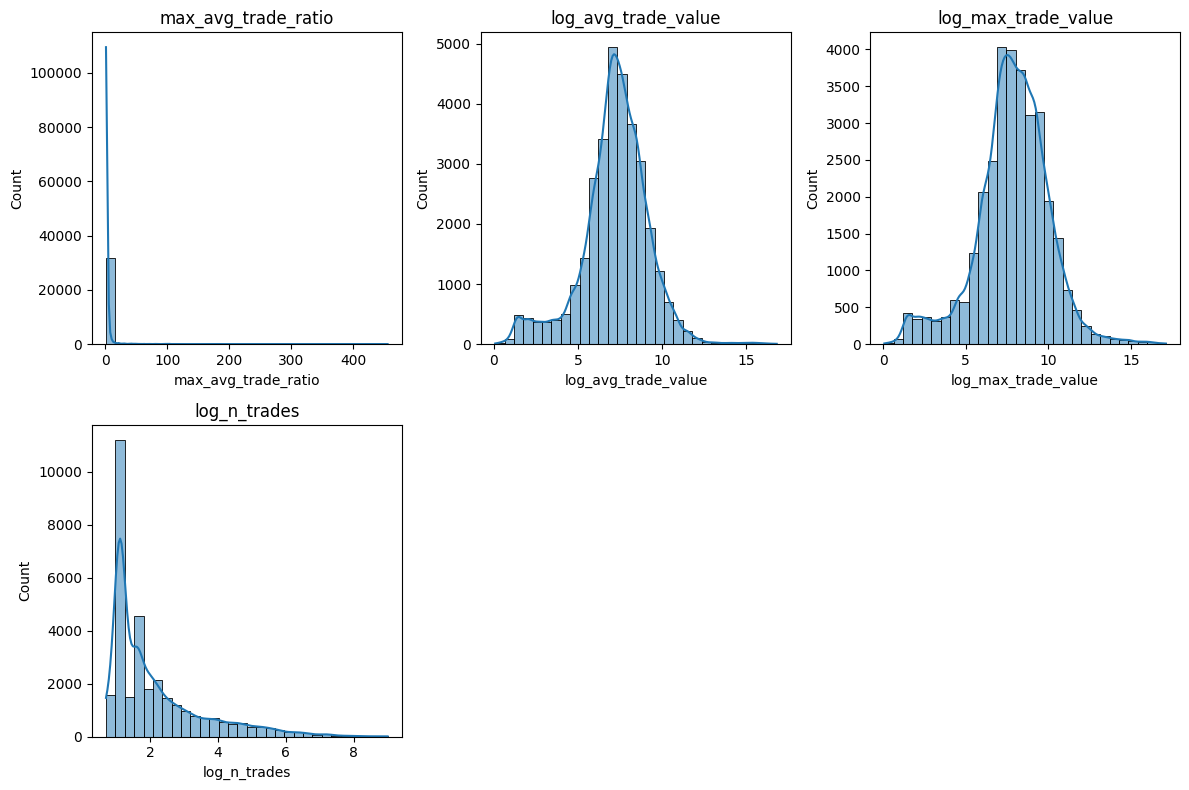

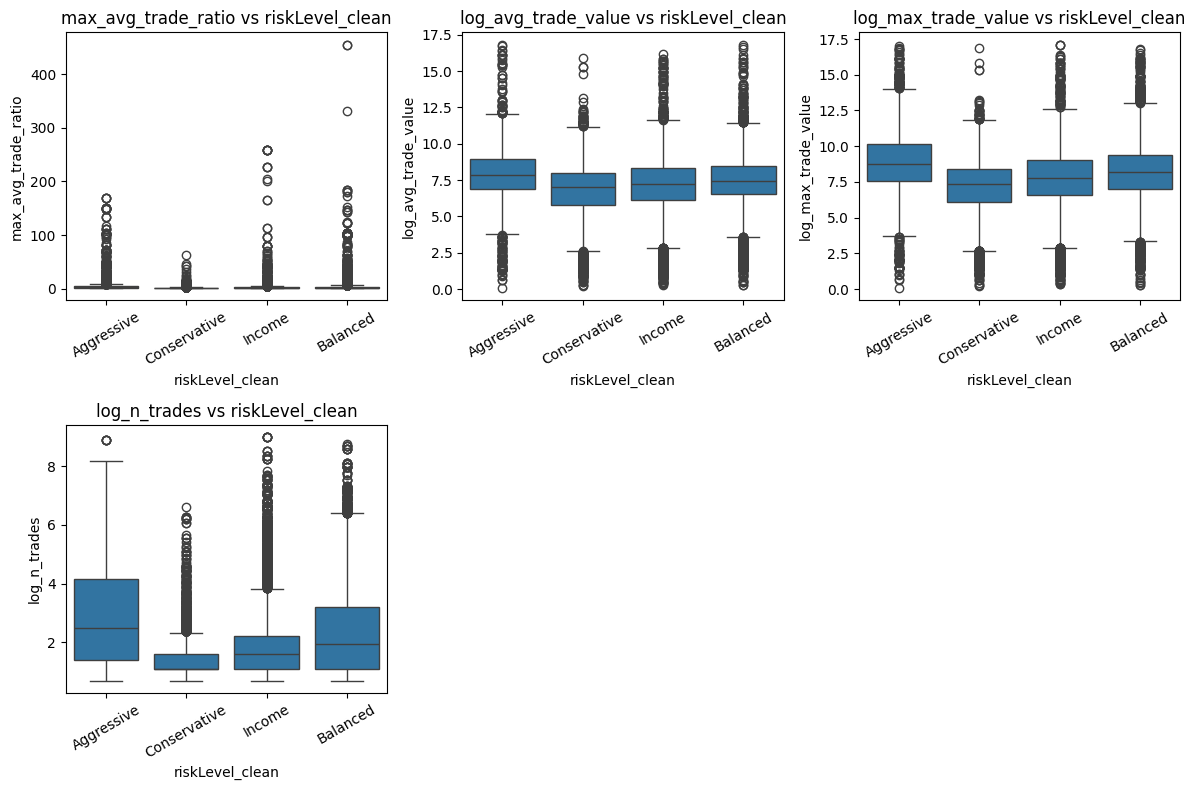

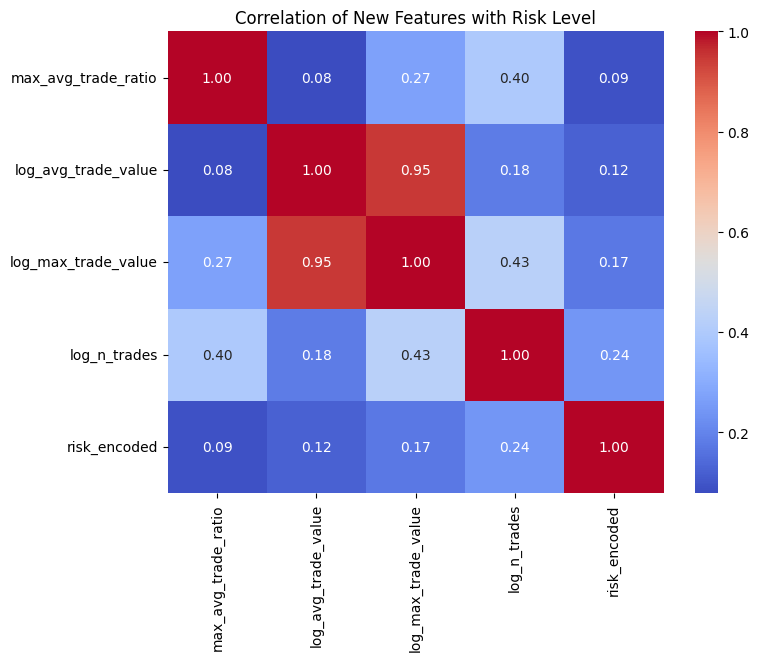

In [4]:
# Cell 4 — Exploratory Analysis of New Features

new_features = [
    "trade_value_volatility",
    "trade_value_rel_volatility",
    "max_avg_trade_ratio",
    "log_avg_trade_value",
    "log_max_trade_value",
    "log_n_trades"
]

# 1. Check summary statistics
print("=== Summary Statistics of New Features ===")
display(far_enhanced[new_features].describe(percentiles=[0.25, 0.5, 0.75]).T)

# 2. Distribution plots
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
for i, col in enumerate(new_features, 1):
    plt.subplot(2, 3, i)
    sns.histplot(far_enhanced[col].dropna(), bins=30, kde=True)
    plt.title(col)
plt.tight_layout()
plt.show()

# 3. Relationship with target variable
plt.figure(figsize=(12, 8))
for i, col in enumerate(new_features, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(data=far_enhanced, x="riskLevel_clean", y=col)
    plt.title(f"{col} vs riskLevel_clean")
    plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

# 4. Correlation heatmap (new features only)
corr = far_enhanced[new_features + ["riskLevel_clean"]].copy()

# Encode riskLevel_clean numerically for correlation (ordinal mapping)
risk_mapping = {"Income": 0, "Conservative": 1, "Balanced": 2, "Aggressive": 3}
corr["risk_encoded"] = corr["riskLevel_clean"].map(risk_mapping)

plt.figure(figsize=(8, 6))
sns.heatmap(corr[new_features + ["risk_encoded"]].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation of New Features with Risk Level")
plt.show()
